In [12]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

        Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  3/10/2004  18:00:00     2.6       1360.0     150.0      11.9   
1  3/10/2004  19:00:00     2.0       1292.0     112.0       9.4   
2  3/10/2004  20:00:00     2.2       1402.0      88.0       9.0   
3  3/10/2004  21:00:00     2.2       1376.0      80.0       9.2   
4  3/10/2004  22:00:00     1.6       1272.0      51.0       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0         1046.0    166.0        1056.0    113.0        1692.0       1268.0   
1          955.0    103.0        1174.0     92.0        1559.0        972.0   
2          939.0    131.0        1140.0    114.0        1555.0       1074.0   
3          948.0    172.0        1092.0    122.0        1584.0       1203.0   
4          836.0    131.0        1205.0    116.0        1490.0       1110.0   

      T    RH      AH  Unnamed: 15  Unnamed: 16  
0  13.6  48.9  0.7578          NaN          NaN  
1  13.3  47.7  0.7255 

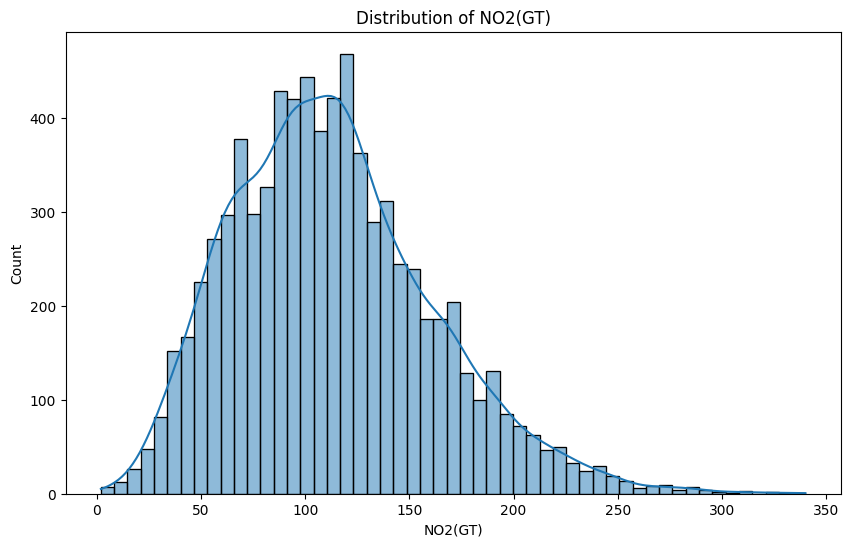

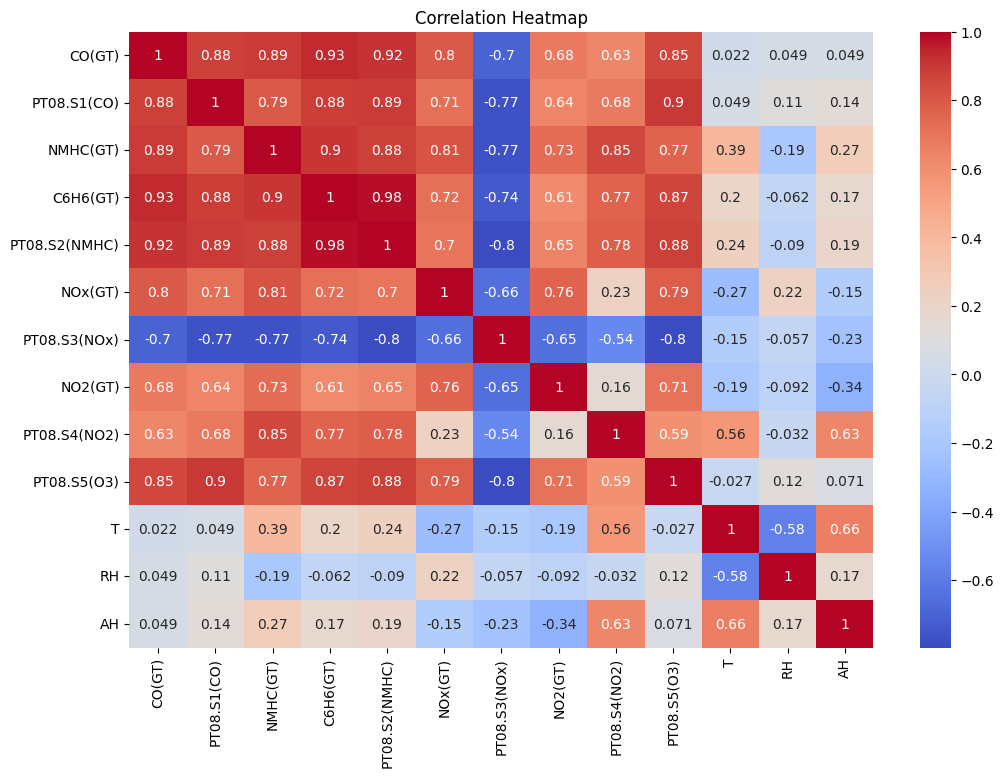

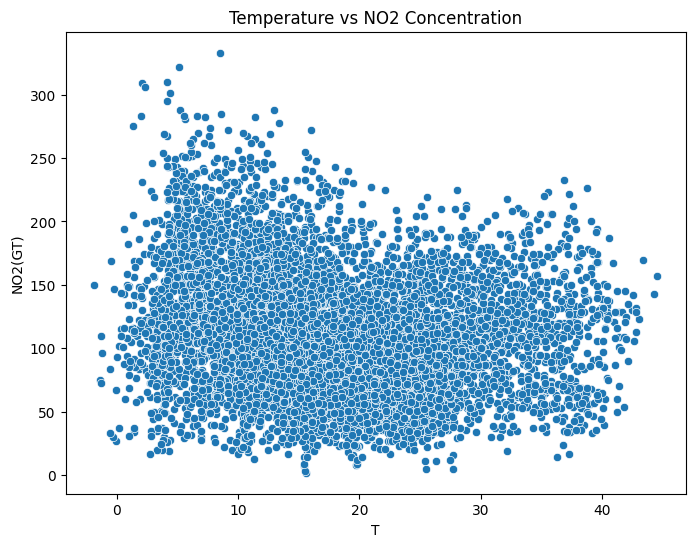

In [13]:
# Step 1: Load Data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AirQualityUCI.csv', delimiter=',')  # Use delimiter if needed for your CSV format
print(df.head())
print(df.info())
print(df.describe())

# Handle missing values: Replace -200 with NaN
df.replace(-200, np.nan, inplace=True)

# Drop unnecessary columns
df.drop(['Date', 'Time', 'Unnamed: 15', 'Unnamed: 16'], axis=1, inplace=True, errors='ignore')  # Adjust if extra columns

# EDA: Visualizations
plt.figure(figsize=(10,6))
sns.histplot(df['NO2(GT)'], kde=True)
plt.title('Distribution of NO2(GT)')
plt.show()

plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Scatter plot example
plt.figure(figsize=(8,6))
sns.scatterplot(x='T', y='NO2(GT)', data=df)
plt.title('Temperature vs NO2 Concentration')
plt.show()

In [14]:
# Step 2: Preprocessing
# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Features and target
X = df_imputed.drop('NO2(GT)', axis=1)
y = df_imputed['NO2(GT)']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Linear Regression CV R2: 0.7331


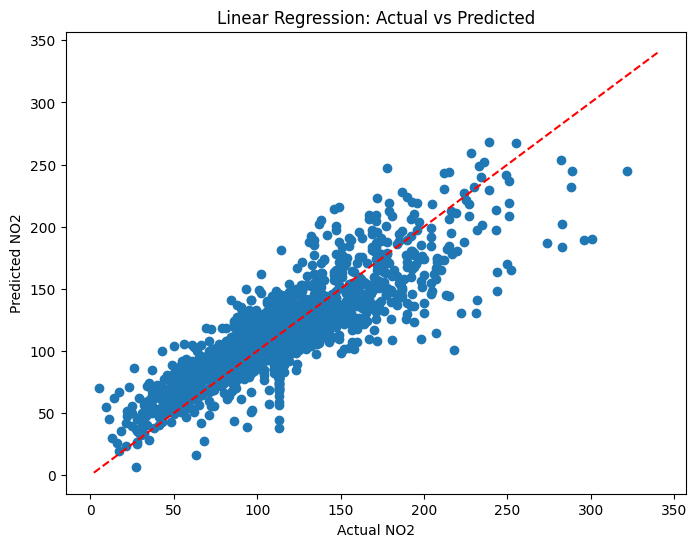

Decision Tree CV R2: 0.7519


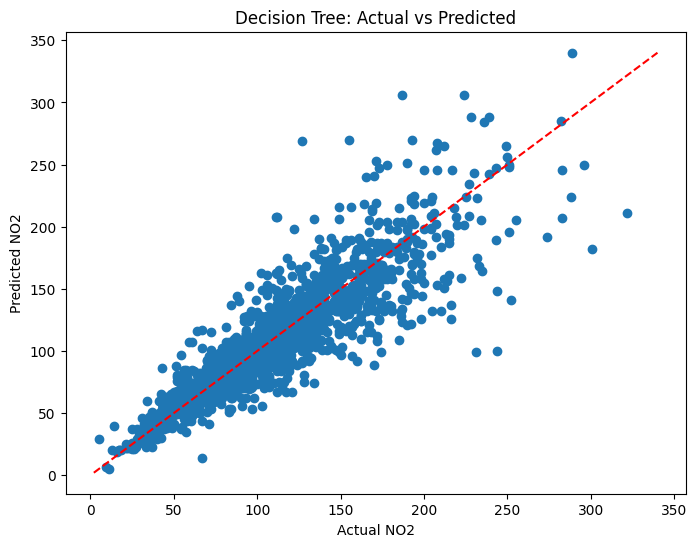

Random Forest CV R2: 0.8816


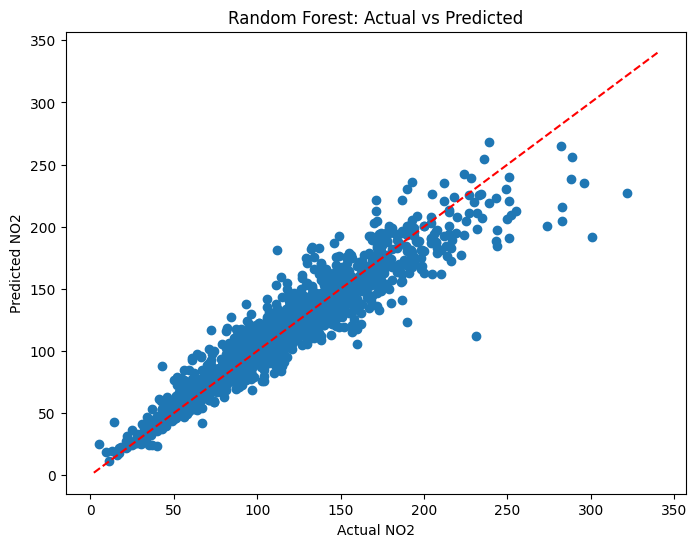

                          MSE       RMSE        R2
Linear Regression  514.276901  22.677674  0.729378
Decision Tree      463.425363  21.527317  0.756137
Random Forest      199.255624  14.115793  0.895148


In [15]:
# Step 3: Modeling
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100)
}

results = {}
for name, model in models.items():
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    print(f'{name} CV R2: {cv_scores.mean():.4f}')

    # Train and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'RMSE': rmse, 'R2': r2}

    # Plot predictions vs actual
    plt.figure(figsize=(8,6))
    plt.scatter(y_test, y_pred)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.title(f'{name}: Actual vs Predicted')
    plt.xlabel('Actual NO2')
    plt.ylabel('Predicted NO2')
    plt.show()

# Compare results
results_df = pd.DataFrame(results).T
print(results_df)

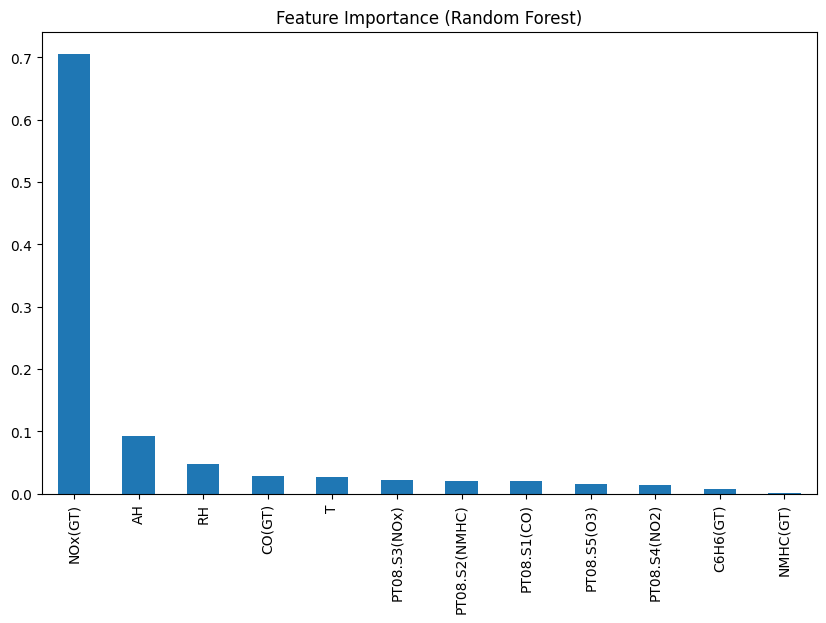

               Importance
NOx(GT)          1.269554
AH               0.188996
RH               0.071332
PT08.S3(NOx)     0.035211
CO(GT)           0.027964
T                0.023330
PT08.S1(CO)      0.020928
PT08.S4(NO2)     0.013766
PT08.S5(O3)      0.013137
PT08.S2(NMHC)    0.010681
C6H6(GT)         0.001889
NMHC(GT)         0.000309


In [16]:
# Step 4: Interpretation - Feature Importance (using Random Forest)
rf_model = models['Random Forest']
importances = rf_model.feature_importances_
feat_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
feat_importance.plot(kind='bar')
plt.title('Feature Importance (Random Forest)')
plt.show()

# Permutation importance for deeper insight
perm_importance = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42)
perm_df = pd.DataFrame({'Importance': perm_importance.importances_mean}, index=X.columns).sort_values('Importance', ascending=False)
print(perm_df)